In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import tree
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import warnings
warnings.filterwarnings('ignore')

# boundries
boundries = [[0.5], [36.5, 91.0], [6.05, 10.95, 11.55], [170.5, 196.0, 368.5], [3.3, 3.75, 10.25], [1.35, 2.1, 2.9],
             [0.35, 0.75, 1.05], [0.05, 0.35], [0.05], [1.7, 223.45], [20.5, 42.0], [41.5, 44.5, 62.5], 
             [45.0, 53.5, 56.5], [13.0,16.5, 169.5], [197.0, 274.5]
             ]

In [3]:
file_name = "Detection of COVID-19 Infection from Routine Blood Exams_dataset.xlsx"
df = pd.read_excel(file_name, sheet_name="Foglio1", nrows=279, usecols="A:P")

means = [61.336917562724, 8.55306859205776, 226.532129963899, 6.20047846889952, 1.18653846153846, 0.605741626794258,
         0.0550239234449761, 0.0144230769230769, 90.889010989011, 54.202166064982, 44.9172932330827, 89.8931297709924, 
         82.4779411764706, 380.448453608247]
# for determine means as nan data
for column, mean in zip(df.columns[1:-1], means):
    df[column].fillna(value=mean, inplace = True)

df['SESSO'].replace(['M','F'], [0,1],inplace=True)
df['TARGET'].replace([1, 2], [1,1], inplace=True)
# pure_df = df.dropna()
pure_df = df
pure_df

,SESSO,AGE,WBC,Piastrine,Neutrofili,Linfociti,Monociti,Eosinofili,Basofili,PCR,AST,ALT,ALP,GGT,LDH,TARGET
0,0,56,2.9,128.0,1.900000,0.800000,0.200000,0.000000,0.000000,29.000000,36.000000,18.000000,43.00000,21.000000,257.000000,1
1,0,56,3.5,151.0,2.100000,0.900000,0.400000,0.000000,0.000000,16.500000,25.000000,14.000000,50.00000,17.000000,207.000000,1
2,0,72,4.6,206.0,6.200478,1.186538,0.605742,0.055024,0.014423,193.700000,31.000000,22.000000,89.89313,82.477941,380.448454,1
3,0,72,16.5,316.0,14.000000,1.200000,0.300000,0.000000,0.000000,318.700000,96.000000,33.000000,80.00000,42.000000,651.000000,1
4,0,77,4.9,198.0,6.200478,1.186538,0.605742,0.055024,0.014423,90.889011,54.202166,44.917293,89.89313,82.477941,380.448454,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,1,40,5.6,270.0,6.200478,1.186538,0.605742,0.055024,0.014423,16.700000,22.000000,29.000000,78.00000,20.000000,380.448454,0
275,0,26,4.7,44.0,6.200478,1.186538,0.605742,0.055024,0.014423,47.500000,30.000000,44.000000,110.00000,93.000000,175.000000,0
276,1,44,15.7,356.0,6.200478,1.186538,0.605742,0.055024,0.014423,2.400000,31.000000,17.000000,89.89313,82.477941,272.000000,0
277,1,41,12.0,321.0,6.700000,2.300000,1.600000,1.300000,0.100000,41.200000,16.000000,11.000000,201.00000,14.000000,266.000000,0


In [4]:
dataset = pure_df.to_numpy()
np.random.seed(54)
train_index = np.random.rand(279) <= 0.7
test_index = np.logical_not(train_index)
train_dataset, test_dataset = dataset[train_index], dataset[test_index]

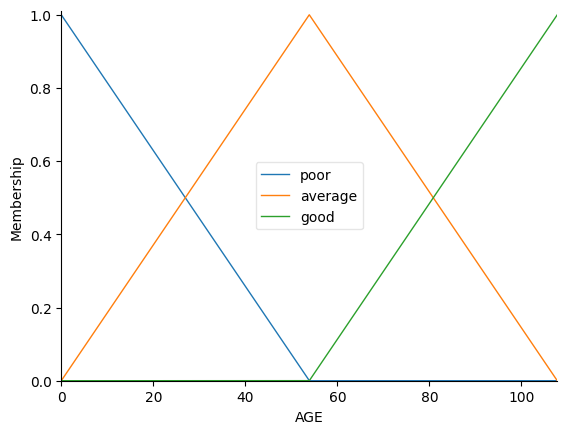

In [5]:
feature_names = ["SESSO", "AGE", "WBC", "Piastrine", "Neutrofili", "Linfociti", "Monociti", "Eosinofili", "Basofili", "PCR", "AST", "ALT", "ALP", "GGT", "LDH"]
all_features = train_dataset[:,0:-1]
all_feature_fuzzy_variables = []

for feature_index in range(15):
    feature_col = all_features[:, feature_index]

    feature_fuzzy_variable = ctrl.Antecedent(np.arange(np.min(feature_col) - 0.01 - (0.1 * np.min(feature_col)), np.max(feature_col) + (0.1 * np.max(feature_col)), 0.01), feature_names[feature_index])
    feature_fuzzy_variable.automf(3)

    all_feature_fuzzy_variables.append(feature_fuzzy_variable)
# for i in range(15):
#     all_feature_fuzzy_variables[i].view()
all_feature_fuzzy_variables[1].view()
covid = ctrl.Consequent(np.arange(0, 1, 0.001), 'covid')
covid['yes'] = fuzz.trimf(covid.universe, [0, 0.5, 1])
no_covid = ctrl.Consequent(np.arange(0,1, 0.001), 'no_covid')
no_covid['yes'] = fuzz.trimf(no_covid.universe, [0, 0.5, 1])



In [6]:
def find_ling_term(feature_value, feature_index):
    bounds = boundries[feature_index]
    fuzzy_variable = all_feature_fuzzy_variables[feature_index]
    values = []
    ling_variables = ["poor", "average", "good"]
    for variable in ling_variables:
        value = fuzz.interp_membership(fuzzy_variable.universe, fuzzy_variable[variable].mf, feature_value)
        values.append(value)
    max_index = values.index(max(values))
    return fuzzy_variable[ling_variables[max_index]]
rules = []

for sample_index in range(train_dataset.shape[0]):
    sample = train_dataset[sample_index, :]
    all_terms = find_ling_term(sample[0], 0)
    for feature_index in range(1, 15):
        all_terms &= find_ling_term(sample[feature_index], feature_index)
    rule = None

    if sample[-1] == 1:
        rule = ctrl.Rule(all_terms, covid['yes'])
    elif sample[-1] == 0:
        rule = ctrl.Rule(all_terms, no_covid['yes'])
    rules.append(rule)

print(rules[0])

IF (((((((((((((SESSO[poor] AND AGE[average]) AND WBC[poor]) AND Piastrine[poor]) AND Neutrofili[poor]) AND Linfociti[poor]) AND Monociti[poor]) AND Eosinofili[poor]) AND Basofili[poor]) AND PCR[poor]) AND AST[poor]) AND ALT[poor]) AND ALP[poor]) AND GGT[poor]) AND LDH[poor] THEN covid[yes]
	AND aggregation function : fmin
	OR aggregation function  : fmax


In [7]:
import pickle
with open('rules.pkl', 'wb') as f:
    pickle.dump(rules, f)

In [8]:
covid_ctrl = ctrl.ControlSystem(rules)
covid_clf = ctrl.ControlSystemSimulation(covid_ctrl)

In [14]:
true = 0
false = 0
for i in range (train_dataset.shape[0]):
    try:
        sample = train_dataset[i,:]

        for feature_index in range(0, 15):
            covid_clf.input[feature_names[feature_index]] = sample[feature_index]
        covid_clf.compute()
        value = fuzz.interp_membership(covid.universe, covid['yes'].mf, covid_clf.output["covid"])
        if value >= 0.5:
            if sample [-1] == 1:
                true += 1
            else: 
                false += 1
        else:
            if sample [-1] == 0:
                true += 1
            else: 
                false += 1
    except:
        print(i)
print(true, false)

18
30
41
96
206
120 83


In [10]:
true / (true + false)

0.5911330049261084

In [27]:
true = 0
false = 0
for i in range (test_dataset.shape[0]):
    try:
        sample = test_dataset[i,:]

        for feature_index in range(0, 15):
            covid_clf.input[feature_names[feature_index]] = sample[feature_index]
        covid_clf.compute()
        value = fuzz.interp_membership(covid.universe, covid['yes'].mf, covid_clf.output["covid"])
        if value >= 0.5:
            if sample [-1] == 1:
                true += 1
            else: 
                false += 1
        else:
            if sample [-1] == 0:
                true += 1
            else: 
                false += 1
    except:
        print(i)
print(true, false)


4
7
8
61
50 17


In [28]:
true / (true + false)

0.746268656716418

SESSO 0.0
AGE 76.0
WBC 23.3
Piastrine 346.0
Neutrofili 6.20047846889952
Linfociti 1.18653846153846
Monociti 0.605741626794258
Eosinofili 0.0550239234449761
Basofili 0.0144230769230769
PCR 125.4
AST 57.0
ALT 30.0
ALP 89.8931297709924
GGT 82.4779411764706
LDH 767.0
OrderedDict([('covid', 0.49999875082711337), ('no_covid', 0.49999855480310357)])


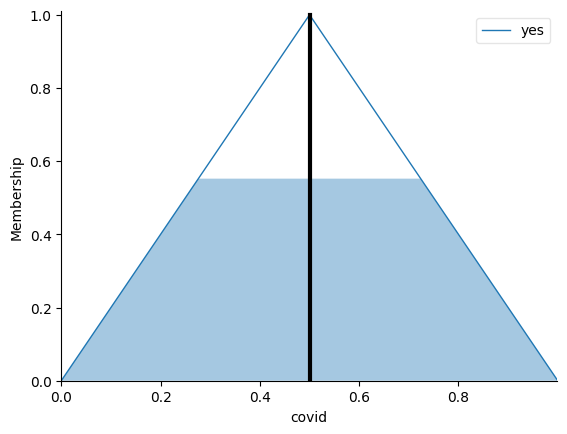

In [21]:
sample = train_dataset[20,:]
for feature_index in range(0, 15):
    print(feature_names[feature_index], sample[feature_index])
    covid_clf.input[feature_names[feature_index]] = sample[feature_index]



covid_clf.compute()
print(covid_clf.output)
covid.view(sim=covid_clf)

OrderedDict([('covid', 0.49999855979977403), ('no_covid', 0.4999980001680686)])


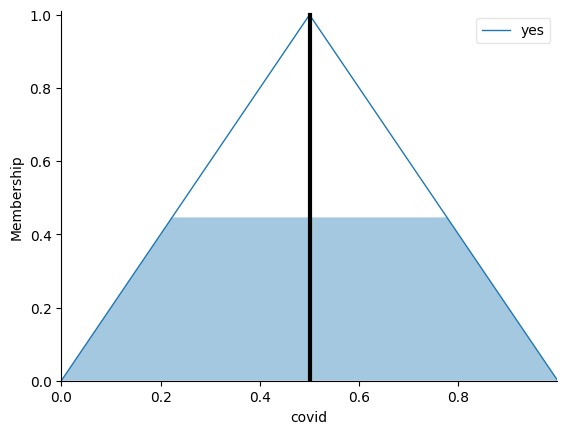

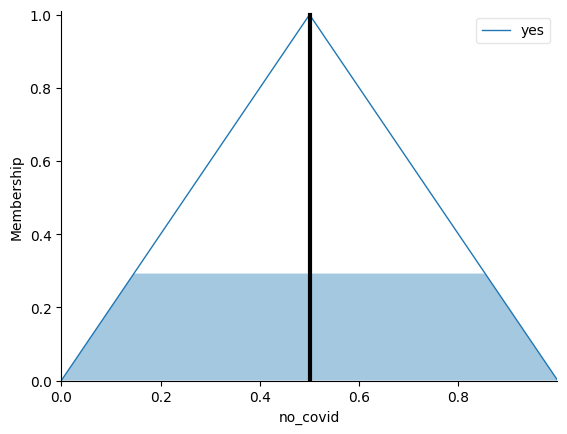

In [43]:
sample = test_dataset[31,:]

for feature_index in range(0, 15):
    # print(feature_names[feature_index], sample[feature_index])
    covid_clf.input[feature_names[feature_index]] = sample[feature_index]

covid_clf.compute()
print(covid_clf.output)
covid.view(sim=covid_clf)
no_covid.view(sim=covid_clf)